Name:   Subrat Kishore Dutta
Matrikelnummer:  7028082
Email:   sudu00001@stud.uni-saarland.de, subratkishoredutta1234@gmail.com
   
Name:   Prathvish Mithare 
Matrikelnummer:   7028692
Email: prmi00001@stud.uni-saarland.de


#### Preamble

In [1]:
# TODO: Import necessary libraries
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
from tqdm import tqdm
from torchmetrics import F1Score
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()
device = torch.device("cpu")

# 8.2 Using different Optimizers

In this exercise you get to use your previously built networks, but this time we will play around with different optimizers and have a brief introduction to schedulers (Bonus)

### 8.2.1 AdaGrad, Adam, SGD

In this exercise reuse your deep regularized network from Assignment 7 (using `torch`) and train your model with different optimizers, namely AdaGrad, Adam, and SGD. (**1 point**)

Report your accuracy and $F_1 score$ matrices for training and test set. Do you see any difference in the matrices with rergards to number of epochs? (**0.5 point**)

Plot the values of your training loss for all three optimizers. Does your observation of differences match what you expected? (**0.5 point**)

In another plot, visualize the weight update trajectories of your model when using different optimizers.

*You should keep in mind that while generating points for plotting, you should keep other hyperparameters constant. This provides you a better sense of performance comparison.*

In [374]:
class Model(nn.Module):
    """
    Reuse your Deep Regularized Network model from last exercise to create this model. It should be possible for your model to use an optimizer
    based on a value passed to the class.
    """
    # TODO: Implement
    def __init__(self, input_dim: int, hidden_dim: int, out_dim: int, num_layers: int, dropout: list, dropout_p: float,
                 l2_reg: bool):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.dropout_p = dropout_p
        self.l2_reg = l2_reg
        layers=[]
        layers.append(nn.Linear(self.input_dim, self.hidden_dim,bias=False))
        layers.append(nn.ReLU())
        for num in range(self.num_layers):
            layers.append(nn.Linear(self.hidden_dim, self.hidden_dim,bias=False))
            layers.append(nn.ReLU())
            if self.dropout[num]:
                layers.append(nn.Dropout(p=self.dropout_p))
        layers.append(nn.Linear(self.hidden_dim,self.out_dim,bias=False))
        layers.append(nn.Softmax())
        self.layers = nn.Sequential(*layers)

    def __call__(self,x):
        out = self.layers(x)
        return out
    
    def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01,opti='adam'):
        optidict={'adagrad':torch.optim.Adagrad(self.parameters(), lr=learning_rate),'adam':torch.optim.Adam(self.parameters(),lr=learning_rate),'sgd':torch.optim.SGD(self.parameters(), lr=learning_rate)}
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optidict[opti]
        if self.l2_reg:
            optimizer.weight_decay = lam #torch.optim.Adam(self.parameters(),lr=learning_rate,weight_decay=lam)
        lossrec=[]
        par=[]## storing value per epoch (layer 1 weight,layer 2 weight, ... , layer n weight)
        for epoch in range(epochs):
            tloss=0
            a = torch.tensor(0.).to(device)
            for i,(xs,ys) in enumerate(train_loader):
                xs=xs.to(device)
                ys=ys.to(device)
                pred = self(xs.view(-1,28*28))
                
                for p in self.parameters():
                    a+=torch.norm(p)
                    #print(a)
                loss = loss_fn(pred,ys) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                tloss+=loss
            
            para=[]## stores all the parameters first dim : layer number second dimenstion: node number third dimension: input weight weight
            for p in self.parameters():
                para.append(p)
            par.append([(para[j][5][1].item(),para[j][3][1].item()) for j in range(self.num_layers+2)])
            lossrec.append((tloss/len(train_loader)).log().item())
            print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item())
            
        
        return lossrec,par
            
    def test(self,test_loader):
        loss_fn = nn.CrossEntropyLoss()
        loss=0
        for i,(xs,ys) in enumerate(test_loader):
            xs=xs.to(device)
            ys=ys.to(device)
            pred = self(xs.view(-1,28*28))
            loss+= loss_fn(pred,ys).item()
        print(loss/len(test_loader))
        return loss/len(test_loader)

In [375]:
#shows update ofthe weights with respect to epochs
def plot(par,lossrec,model):
    fig, axs = plt.subplots(1,2,figsize=(20,7))
    axs[0].set_title('epoch vs log loss')
    axs[0].plot(range(len(lossrec)),lossrec,color='orange')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('log loss')
    for numb in range(model.num_layers):
        axs[1].plot(range(len(par)),torch.tensor(par)[:,numb,1],marker='o',label='layer '+str(numb)+' 6th node 2nd weight ')
    axs[1].set_ylabel('weights')
    axs[1].set_xlabel('epochs')
    axs[1].set_title('weight update trajectories over epochs ')
    axs[1].legend()
    plt.show()

In [488]:
def wwplot(par1,par2,par3,numb):
    plt.figure(figsize=(5,5))
    plt.title('weight update trajectory')
    plt.xlabel('w1')
    plt.ylabel('w2')
    plt.plot(torch.tensor(par1)[:,numb,0],torch.tensor(par1)[:,numb,1],marker='o',label='layer '+str(numb)+' AdaGrad',color='purple',alpha=0.7)
    plt.plot(torch.tensor(par2)[:,numb,0],torch.tensor(par2)[:,numb,1],marker='o',label='layer '+str(numb)+' Adam',color='orange',alpha=0.7)
    plt.plot(torch.tensor(par3)[:,numb,0],torch.tensor(par3)[:,numb,1],marker='o',label='layer '+str(numb)+' SGD',color='black',alpha=0.7)
    for i in range(0,len(torch.tensor(par1)),20):
        plt.text(torch.tensor(par1)[i,numb,0],torch.tensor(par1)[i,numb,1],'ep'+str(i),fontsize=5)
    for i in range(0,len(torch.tensor(par2)),20):
        plt.text(torch.tensor(par2)[i,numb,0],torch.tensor(par2)[i,numb,1],'ep'+str(i),fontsize=5)
    for i in range(0,len(torch.tensor(par3)),20):
        plt.text(torch.tensor(par3)[i,numb,0],torch.tensor(par3)[i,numb,1],'ep'+str(i),fontsize=5)
    plt.legend()
    plt.show()

In [377]:
##function to get accuracy:
def get_accuracy(data,model):
    accdata=torch.utils.data.DataLoader(data,batch_size=len(data))
    for X,Y in accdata:
        X=X.to(device)
        Y=Y.to(device)
        ypred=model(X.view(-1,28*28))
        train_acc = torch.sum(ypred.argmax(1) == Y)
        accuracy = train_acc/len(data)
    print(accuracy.item()*100,"%")

In [378]:
def get_f1(data,model):
    accdata=torch.utils.data.DataLoader(data,batch_size=len(data))
    for X,Y in accdata:
        X=X.to(device)
        Y=Y.to(device)
        f1= F1Score(task="multiclass", num_classes=10)
        ypred=model(X.view(-1,28*28))
        f1 = f1(ypred.argmax(1),Y)
    print("F1 score:",f1.item())

In [379]:
# Load the data
# DO NOT CHANGE THE CODE IN THIS CELL EXCEPT FOR THE BATCH SIZE IF NECESSARY
transform_fn = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_fn)
train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_fn)
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=False)

# Use the above data for your experiments

In [435]:
## first model with AdaGrad
model1 = Model(28*28, 300, 10,4, [1,1,1,1,1],0.05,True)
model1.to(device)

Model(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=False)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=False)
    (3): ReLU()
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=300, out_features=300, bias=False)
    (6): ReLU()
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=300, out_features=300, bias=False)
    (9): ReLU()
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=300, out_features=300, bias=False)
    (12): ReLU()
    (13): Dropout(p=0.05, inplace=False)
    (14): Linear(in_features=300, out_features=10, bias=False)
    (15): Softmax(dim=None)
  )
)

In [438]:
#storing the history
loss1T=[]
par1T=[]

In [467]:
# TODO: Run your experiments and plot the results   #6-0.1 300-0.01
loss1,par1=model1.train(train_dl,epochs = 50, learning_rate=0.0001,lam=0.001,opti='adagrad')
loss1T+=loss1
par1T+=par1
print("Loss on test:")
model1.test(test_dl)
print("Training accuracy:")
get_accuracy(mnist_train,model1)
print("Test accuracy:")
get_accuracy(mnist_test,model1)
print("Training f1 score:")
get_f1(mnist_train,model1)
print("Test f1 score:")
get_f1(mnist_test,model1)

epoch: 0 loss: 1.4922590255737305
epoch: 1 loss: 1.4910058975219727
epoch: 2 loss: 1.4909229278564453
epoch: 3 loss: 1.4906537532806396
epoch: 4 loss: 1.4906524419784546
epoch: 5 loss: 1.4908325672149658
epoch: 6 loss: 1.4901342391967773
epoch: 7 loss: 1.490464448928833
epoch: 8 loss: 1.490537166595459
epoch: 9 loss: 1.4906466007232666
epoch: 10 loss: 1.4903608560562134
epoch: 11 loss: 1.4901739358901978
epoch: 12 loss: 1.4898655414581299
epoch: 13 loss: 1.4900879859924316
epoch: 14 loss: 1.4900758266448975
epoch: 15 loss: 1.4899778366088867
epoch: 16 loss: 1.490017056465149
epoch: 17 loss: 1.4898923635482788
epoch: 18 loss: 1.4895321130752563
epoch: 19 loss: 1.4897546768188477
epoch: 20 loss: 1.489620566368103
epoch: 21 loss: 1.4897117614746094
epoch: 22 loss: 1.4898170232772827
epoch: 23 loss: 1.4894484281539917
epoch: 24 loss: 1.4891380071640015
epoch: 25 loss: 1.4896628856658936
epoch: 26 loss: 1.4894986152648926
epoch: 27 loss: 1.4895793199539185
epoch: 28 loss: 1.4897574186325073

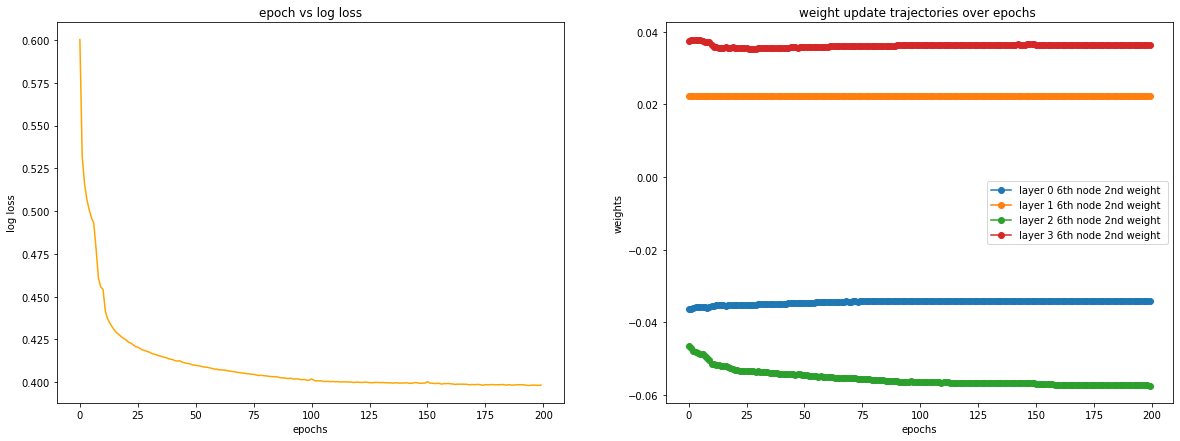

In [468]:
plot(par1T,loss1T,model1)

In [451]:
## second model with Adam
model2 = Model(28*28, 300, 10,4, [1,1,1,1,1],0.05,True)
model2.to(device)

Model(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=False)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=False)
    (3): ReLU()
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=300, out_features=300, bias=False)
    (6): ReLU()
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=300, out_features=300, bias=False)
    (9): ReLU()
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=300, out_features=300, bias=False)
    (12): ReLU()
    (13): Dropout(p=0.05, inplace=False)
    (14): Linear(in_features=300, out_features=10, bias=False)
    (15): Softmax(dim=None)
  )
)

In [452]:
#storing the history
loss2T=[]
par2T=[]

In [454]:
loss2,par2=model2.train(train_dl,epochs = 195, learning_rate=0.0001,lam=0.001,opti='adam')
print("Loss on test:")
model2.test(test_dl)
print("Training accuracy:")
get_accuracy(mnist_train,model2)
print("Test accuracy:")
get_accuracy(mnist_test,model2)
print("Training f1 score:")
get_f1(mnist_train,model2)
print("Test f1 score:")
get_f1(mnist_test,model2)
loss2T+=loss2
par2T+=par2

epoch: 0 loss: 1.526736855506897
epoch: 1 loss: 1.5224534273147583
epoch: 2 loss: 1.5169576406478882
epoch: 3 loss: 1.5139541625976562
epoch: 4 loss: 1.5124270915985107
epoch: 5 loss: 1.5065139532089233
epoch: 6 loss: 1.5053305625915527
epoch: 7 loss: 1.5034701824188232
epoch: 8 loss: 1.5020992755889893
epoch: 9 loss: 1.5009609460830688
epoch: 10 loss: 1.499829649925232
epoch: 11 loss: 1.4986294507980347
epoch: 12 loss: 1.4983501434326172
epoch: 13 loss: 1.498660683631897
epoch: 14 loss: 1.4951133728027344
epoch: 15 loss: 1.497586727142334
epoch: 16 loss: 1.4952671527862549
epoch: 17 loss: 1.4939825534820557
epoch: 18 loss: 1.4941049814224243
epoch: 19 loss: 1.4938504695892334
epoch: 20 loss: 1.492835521697998
epoch: 21 loss: 1.4914393424987793
epoch: 22 loss: 1.4918997287750244
epoch: 23 loss: 1.490691900253296
epoch: 24 loss: 1.489793300628662
epoch: 25 loss: 1.4905227422714233
epoch: 26 loss: 1.4893555641174316
epoch: 27 loss: 1.4909461736679077
epoch: 28 loss: 1.4894477128982544
ep

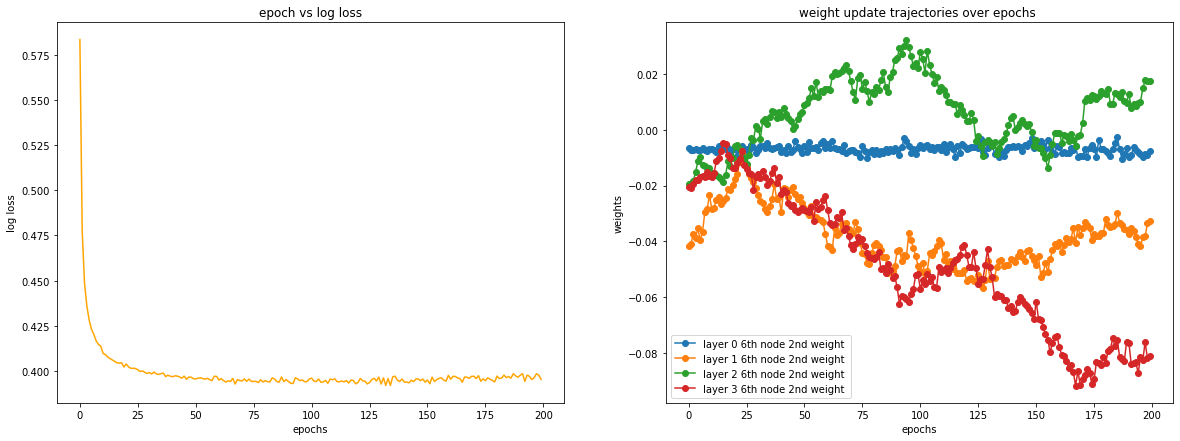

In [455]:
plot(par2T,loss2T,model2)

In [456]:
model3 = Model(28*28, 300, 10,4, [1,1,1,1,1],0.05,True)
model3.to(device)

Model(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=False)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=False)
    (3): ReLU()
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=300, out_features=300, bias=False)
    (6): ReLU()
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=300, out_features=300, bias=False)
    (9): ReLU()
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=300, out_features=300, bias=False)
    (12): ReLU()
    (13): Dropout(p=0.05, inplace=False)
    (14): Linear(in_features=300, out_features=10, bias=False)
    (15): Softmax(dim=None)
  )
)

In [457]:
#storing the history
loss3T=[]
par3T=[]

In [465]:
loss3,par3=model3.train(train_dl,epochs = 50, learning_rate=0.0001,lam=0.001,opti='sgd')
loss3T+=loss3
par3T+=par3
print("Loss on test:")
model3.test(test_dl)
print("Training accuracy:")
get_accuracy(mnist_train,model3)
print("Test accuracy:")
get_accuracy(mnist_test,model3)
print("Training f1 score:")
get_f1(mnist_train,model3)
print("Test f1 score:")
get_f1(mnist_test,model3)

epoch: 0 loss: 1.5176222324371338
epoch: 1 loss: 1.5175074338912964
epoch: 2 loss: 1.517502784729004
epoch: 3 loss: 1.517775058746338
epoch: 4 loss: 1.5172734260559082
epoch: 5 loss: 1.517240047454834
epoch: 6 loss: 1.5173901319503784
epoch: 7 loss: 1.517555594444275
epoch: 8 loss: 1.5175849199295044
epoch: 9 loss: 1.5173461437225342
epoch: 10 loss: 1.5173858404159546
epoch: 11 loss: 1.517276644706726
epoch: 12 loss: 1.5173553228378296
epoch: 13 loss: 1.5176693201065063
epoch: 14 loss: 1.5170549154281616
epoch: 15 loss: 1.517235279083252
epoch: 16 loss: 1.517121434211731
epoch: 17 loss: 1.5172464847564697
epoch: 18 loss: 1.5171817541122437
epoch: 19 loss: 1.517411470413208
epoch: 20 loss: 1.516716718673706
epoch: 21 loss: 1.517221450805664
epoch: 22 loss: 1.5170742273330688
epoch: 23 loss: 1.5169382095336914
epoch: 24 loss: 1.5166517496109009
epoch: 25 loss: 1.5168664455413818
epoch: 26 loss: 1.516871690750122
epoch: 27 loss: 1.5167027711868286
epoch: 28 loss: 1.5168442726135254
epoch:

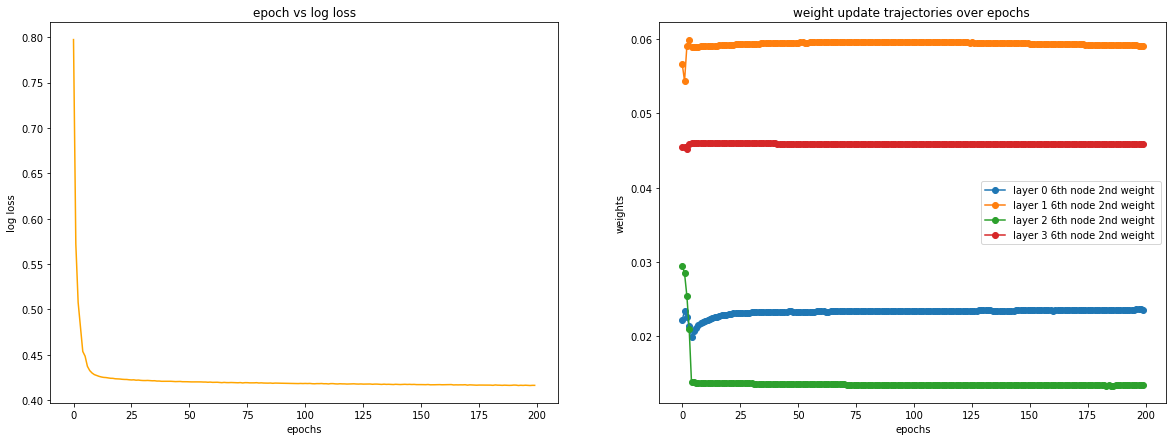

In [466]:
plot(par3T,loss3T,model3)

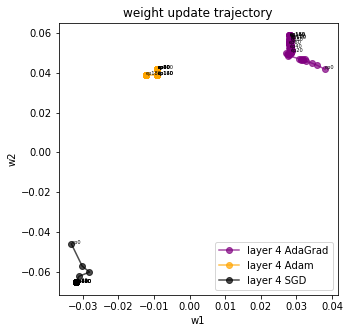

In [490]:
wwplot(par1T,par2T,par3T,4)

<b>Q</b> Report your accuracy and  𝐹1𝑠𝑐𝑜𝑟𝑒  matrices for training and test set. Do you see any difference in the matrices with rergards to number of epochs? (0.5 point)

<b>Ans</b>:
After training for 150 epochs we saw that the model achieved the following scores for train and test set accuracy and F1 scores:

Model with adagrad: 

    Training accuracy: 97.358%  Training F1 score: 0.973

    Test accuracy: 96.299 Testing F1 score: 0.962

Model with adam:

    Training accuracy: 97.728%  Training F1 score: 0.977

    Test accuracy: 96.95% Testing F1 score: 0.969

Model with sgd:
    
    Training accuracy: 94.58%  Training F1 score: 0.9459

    Test accuracy: 94.30% Testing F1 score: 0.9424

from the training graph it is evident that the model with SGD converged the fastest followed by Adam and then AdaGrad.

<b>Q</b> Plot the values of your training loss for all three optimizers. Does your observation of differences match what you expected? (0.5 point)
<b>Ans</b>: 

The least training loss acheived by Adam was 1.4889

The least training loss acheived by Adam was 1.4799

The least training loss acheived by SGD was 1.5161

The results are expected as Adam acheives the least training loss

##### Some other observations:

1. SGD model generalises the best with very little difference between training and testing accuracy.
2. SGD converges the fastest.
3. The training to testing accuracy difference is comparable in both AdaGrad and Adam optimisation

### 8.2.2 Schedulers (1 point) (**Bonus**)

In `torch.optim` module, we have a functionality called `scheduler` https://pytorch.org/docs/stable/optim.html & in several different flavour of schedulers i.e. in Pytorch Ignite and HuggingFace, we have a functionality called `warmup_steps`. Briefly explain why would we need to use a scheduler with warmup steps.

#### Answer:
warmup steps in schedular means that often times the learning rate is increased in the inital few iterations of training. This improves the stability of the training process and also prevents the model from converging at a  suboptimal minima. If the learning rate is kept very high in the initial steps it can lead to model's loss oscillating over the loss landscape and it may show divergent behavior. starting slow gives the model a good initialisation.